# Explainable reasoning with ChiRho (categorical variables)

The **Explainable Reasoning with ChiRho** package aims to provide a systematic, unified approach to causal explanation computations in terms of different probabilistic queries over expanded causal models that are constructed from a single generic program transformation applied to an arbitrary causal model represented as a ChiRho program. The approach of reducing causal queries to probabilistic computations on transformed causal models is the foundational idea behind all of ChiRho. The key strategy underlying "causal explanation" queries is their use of auxiliary variables representing uncertainty about what the proposed interventions are and which interventions or preemptions to apply, implicitly inducing a search space over counterfactuals.

The goal of this notebook is to illustrate how the package can be used to provide an approximate method of answering a range of causal explanation queries with respect to models in which categorical variables play the key role. As the key tool will involve sampling-based posterior probability estimation, a lot of what will be said *mutatis mutandis* applies to more general settings where variables are continuous (to which we will devote another tutorial).

In yet [another notebook](https://basisresearch.github.io/chirho/actual_causality.html) we illustrate how the module allows for a faithful reconstruction of a particular notion of local explanation (the so-called Halpern-Pearl modified definition of actual causality [(J. Halpern, MIT Press, 2016)](https://mitpress.mit.edu/9780262537131/actual-causality/)), which inspired some of the conceptual steps underlying the current implementation.

**Outline**

[Causal explanation and counterfactual thinking](#causal-explanation-and-counterfactual-thinking)     


[Witness nodes and context sensitivity](#witness-nodes-and-context-sensitivity)

[Probability of causation and responsibility](#probability-of-causation-and-responsibility)

## Causal explanation and counterfactual thinking

Consider the following causality-related queries:

- **Friendly Fire:** On March 24, 2002, A B-52 bomber fired a Joint Direct Attack Munition at a US battalion command post, killing three and injuring twenty special forces soldiers. Out of multiple potential contributing factors, which were actually responsible for the incident?

- **Overshoot:** In dealing with an epidemic, multiple different policies were imposed, leading to the overshoot (the number of those who became infected after the peak of the epidemic) rising from around 15% in the unintervened model to around 25%. Which of the policies caused the overshoot and to what extent?

- **Explainable AI:** Your pre-trial release has been refused based on your [COMPAS score](https://en.wikipedia.org/wiki/COMPAS_(software)). The decision was made using a proprietary predictive model. All you have access to is the questionnaire that was used, and perhaps some demographic information about a class of human beings subjected to this evaluation. But which of these factors resulted in your score being what it is, and what were their contributions?


Questions of this sort are more local than those pertaining to average treatment effects, as they pertain to actual cases that come with their own contexts. Being able to answer them is useful for understanding how we can prevent undesirable outcomes similar to ones that we have observed, or promote the occurrence of desirable outcomes in contexts similar to the ones in which they had been observed. These context-sensitive causality questions are also an essential element of blame and responsibility assignments. If the phenomenon we're trying to explain is the behavior of a predictive model, we are dealing with a problem in explainable AI; but the underlying intuition behind the workings of **Explainable Reasoning with ChiRho** is that causally explaining the behavior of an opaque model is not that much different from providing a causal explanation of other real-world phenomena: we need to address such queries in a principled manner employing some approximate but hopefully reliable causal model of how things work (be that events outside of computers, or a predicitive model's behavior). **Explainable Reasoning with ChiRho** package aims to provide a unified general approach to the relevant causal explanation computations.

At some level of generality, a useful point of departure is a general counterfactual one. On one hand, we can ask whether the event would have occurred had a given candidate cause not taken place. This is sometimes called  the *but-for test*, has a tradition of being used as a tool for answering causality and attribution queries. 

- It is often used in [the law of torts](https://plato.stanford.edu/entries/causation-law/) to determine if a defendant's conduct was the cause of a particular harm. The test is often formulated as follows: "But for the defendant's conduct, would the harm have occurred?" 
- A major philosophical position in the analysis of causality is that the definition of causal dependence should be formulated in terms of counterfactual conditionals (Lewis, 1973. “Causation”, Journal of Philosophy, 70: 556–67). On this approach, $e$ causally depends on $c$ if and only if, if $c$ were not to occur $e$ would not occur. (The view does not remain uncontested, see the [SEP entry on counterfactual theories of causation](https://plato.stanford.edu/entries/causation-counterfactual/)).
- At least a few major approaches to explainable AI (such as [LIME](https://arxiv.org/abs/1602.04938),  or [Shapley values](https://papers.nips.cc/paper_files/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html))  are based on the idea that explanations can be obtained by perturbing or shifting the input values and observing the changes in the output. This to a large extent can be thought of as a way of evaluating the but-for condition: if the input value was different, would the output value change? 
 
More generally, we can ask about the probability with which an alterantive intervention would lead to a cahnge in the outcome (perhaps while conditioning on other items of information), in line with the ideas present in Pearl's *Probabilities of causation...* and Chapter 9 of Pearl's *Causality*. While immensely useful, the but-for condition is not fine-grained enough to answer all the questions we are interested in or to give us the intended answers in cases in which the underlying causal model is non-trivial. We will illustrate this observation in this tutorial. 


On the other hand, we can ask whether given our model (and perhaps conditioning on other pieces of information we posses), intervening on a given candidate cause to have a given value results in the outcome being as observed (or, more generally, the probability of that outcome being as observed) - this is conceptually similar to Pearl's probability of sufficiency. 

We will start with these two approaches, but soon we will notice that often our explanatory questions are more local and a more fine-grained tool is needed. The general intuition (inspired by Halpern's *Actual Causality*) that we implemented is that when we ask local explanatory questions, we need to keep some part of the actual context fixed and consider alternative scenarios insofar as potential causes are involved. That is, we (i) search through possible alternative interventions that could be performed on the candidate cause nodes, (ii) search through possible context nodes that are to be intervened to be at their factual values even in the counterfactual worlds, (iii) see how these options play out in intervened worlds, and (iv) investigate and meaningfully summarize what happens with the outcome nodes of interest in all those counterfactual worlds. 

Let's start with a very simple model, in which a forest fire can be caused by exactly one of two things: a match being dropped (`match_dropped`), or a lightning strike (`lightning`), and either of these factors alone is already deterministically sufficient for the `forest_fire` to occur. A match being dropped is more likely than a lightning strike (we use fairly large probabilities for the sake of example transparency). For the sake of illustration, we also include a causally irrelevant site representing whether a ChiRho developer smiles, `smile`.

In [154]:
%env CUDA_VISIBLE_DEVICES=-1
from typing import Callable, Dict, List, Optional

import math
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import torch
from chirho.counterfactual.handlers.counterfactual import \
    MultiWorldCounterfactual
from chirho.explainable.handlers import ExtractSupports, SearchForExplanation
from chirho.indexed.ops import IndexSet, gather
from chirho.observational.handlers import condition
from chirho.observational.handlers.soft_conditioning import soft_eq, KernelSoftConditionReparam

pyro.settings.set(module_local_params=True)

env: CUDA_VISIBLE_DEVICES=-1


In [250]:
def importance_infer(
    model: Optional[Callable] = None, *, num_samples: int
):
    
    if model is None:
        return lambda m: importance_infer(m, num_samples=num_samples)

    def _wrapped_model(
        *args,
        **kwargs
    ):

        guide = pyro.poutine.block(hide_fn=lambda msg: msg["is_observed"])(model)

        max_plate_nesting = 9  # TODO guess

        with pyro.poutine.block(), MultiWorldCounterfactual() as mwc:
            log_weights, importance_tr, _ = pyro.infer.importance.vectorized_importance_weights(
                model,
                guide,
                *args,
                num_samples=num_samples,
                max_plate_nesting=max_plate_nesting,
                normalized=False,
                **kwargs
            )

            # # resample using importance weights to get posterior samples
            # idx = dist.Categorical(logits=log_weights).sample((num_samples,))
            # for name, node in importance_tr.nodes.items():
            #     if node["type"] != "sample" or pyro.poutine.util.site_is_subsample(node) or node["is_observed"]:
            #         continue
            #     importance_tr.nodes[name]["value"] = torch.index_select(
            #         importance_tr.nodes[name]["value"],
            #         -max_plate_nesting - 1 - len(importance_tr.nodes[name]["fn"].event_shape),
            #         idx,
            #     )

        print(log_weights)

        # with pyro.poutine.replay(trace=importance_tr), mwc:
        #     trace = pyro.poutine.trace(model).get_trace(*args, **kwargs)

        return torch.logsumexp(log_weights, dim=0) - math.log(num_samples), importance_tr, mwc, log_weights

    return _wrapped_model

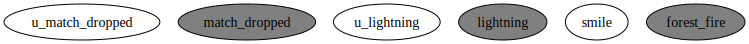

In [156]:
def forest_fire_model():
    u_match_dropped = pyro.sample("u_match_dropped", dist.Bernoulli(0.7))
    match_dropped = pyro.deterministic(
        "match_dropped", u_match_dropped, event_dim=0
    )  # notice uneven probs here

    u_lightning = pyro.sample("u_lightning", dist.Bernoulli(0.4))
    lightning = pyro.deterministic("lightning", u_lightning, event_dim=0)

    # this is a causally irrelevant site
    smile = pyro.sample("smile", dist.Bernoulli(0.5))

    forest_fire = pyro.deterministic(
        "forest_fire", torch.max(match_dropped, lightning) + (0 * smile), event_dim=0
    )

    return {
        "match_dropped": match_dropped,
        "lightning": lightning,
        "forest_fire": forest_fire,
    }

with ExtractSupports() as extract_supports:
    forest_fire_model()
    forest_fire_supports = {k: constraints.boolean for k in extract_supports.supports}

pyro.render_model(forest_fire_model)

Throughout this tutorial, we assume all nodes are binary and use $'$ as negation. Once we specify (i) the distributions for the nodes we use (`supports`), (ii) candidate causes $X_i = x_i$ (`antecedents`) (iii) their alternative values ($X_i = x_i'$), (iv) elements of the current context (`witnesses`), and  (v) the `consequents` of interest $Y=y$. The  `SearchForExplanation` handler transforms the original model into one in which interventions and alternative interventions on the antecedents are applied in parallel counterfactual worlds stochastically preempted and context elements are stochastically selected and preempted to be kept at the factual values in all counterfactual worlds.

First, let's go back to our original query. Let $F$ be the `forest_fire`, $f$ stand for $F=1$, $f'$ for $F=0$, $M$ stand for `match_dropped`, with analogous conventions. We also place interventions conditioned on in subscripts, so that, for example
$P(f_{m'})$ stands for $P(F=1\vert do(M=0))$.

We are currently interested in $P(f'_{m'}, f_m)$, that is the probability of both forest fire not occurring if we intervene on the match to not be dropped, and forest fire occurring if we intervene on the match to be dropped.

First, suppose we are interested in asking the question of whether dropping a match has causal power over whether the forest fire occurs. We assume all relevant nodes are binary. The potential cause (`antecedent`) we're considering is `match_dropped=1`, we contrast it with what would happen if we intervened on it to not happen (`alternatives`). We are interested in whether an outcome variable (`consequent`) has value 1 under these two interventions. The counterfactual world in which we intervene with `alternatives` is world 1, and the counterfactual world in which we intervene with `antecedents` is world 2. We will be interested in cases in which none of these interventions have been preempted (more about this later), so we will sample with appropriate masks as well.

In [157]:
query = SearchForExplanation(
    supports=forest_fire_supports,
    antecedents={"match_dropped": torch.tensor(1.0)},
    consequents={"forest_fire": torch.tensor(1.0)},
    witnesses={}, # potential context elements, we leave them empty for now
    alternatives={"match_dropped": torch.tensor(0.0)},
    consequent_scale=1e-5,
)(forest_fire_model)

logp, trace, mwc = importance_infer(num_samples=10)(query)()
print(torch.exp(logp))

tensor(0.3000)


In [158]:
print(trace.nodes["match_dropped"]["value"].shape)
print(trace.nodes["__cause____antecedent_match_dropped"]["value"].shape)

torch.Size([10, 1, 1, 1, 1, 1, 1, 1, 1, 1])
torch.Size([10, 1, 1, 1, 1, 1, 1, 1, 1, 1])


More interestingly, in cases of overdetermination, a similar estimation would lead us to assign no causal role to any of to co-contributing factors. This can be seen in the context in which both causes occurred. Trivially, if lightning occurred, then had no match been dropped, the forest fire, caused by lighning, would still occur (a symmetric reasoning goes through for the lightning as well), $P(f'_{m'}\vert m, l) = P(f'_{l'}\vert m, l)=0$. Intuitively, these quantities are not good guides to the causal role of `match_dropped` and `lightning`, as we think they did played a causal role. This is the first illustration of why the but-for analysis is not fine-grained enough.

In [159]:
query = SearchForExplanation(
    supports=forest_fire_supports,
    antecedents={"match_dropped": torch.tensor(1.0)},
    consequents={"forest_fire": torch.tensor(1.0)},
    witnesses={}, # potential context elements, we leave them empty for now
    alternatives={"match_dropped": torch.tensor(0.0)},
    consequent_scale=1e-5,
)(condition(
    data={"match_dropped": torch.tensor(1.0), "lightning": torch.tensor(1.0)}
)(forest_fire_model))

logp, trace, mwc = importance_infer(num_samples=10000)(query)()
print(torch.exp(logp))

tensor(1.0013e-05)


Comment: The ground truth example for correct intervention. This gives 0.42 as the answer which is the expected answer.

In [160]:
print(forest_fire_supports)

{'u_match_dropped': Boolean(), 'match_dropped': Boolean(), 'u_lightning': Boolean(), 'lightning': Boolean(), 'smile': Boolean(), 'forest_fire': Boolean()}


In [175]:

import math
# reparam_config = AutoSoftConditioning(scale=math.sqrt(1/(2*math.pi)))
# def _soft_eq(v1: torch.Tensor, v2: torch.Tensor) -> torch.Tensor:
#     return soft_eq(constraints.boolean, v1, v2, scale=scale)
# reparam_config = {"match_dropped": KernelSoftConditionReparam(_soft_eq)}

def _soft_eq(v1: torch.Tensor, v2: torch.Tensor) -> torch.Tensor:
            return soft_eq(constraints.boolean, v1, v2, scale=0.001)

reparam_config = {"match_dropped": KernelSoftConditionReparam(_soft_eq)}


query = SearchForExplanation(
    supports=forest_fire_supports,
    antecedents={"match_dropped": torch.tensor(1.0)},
    consequents={"forest_fire": torch.tensor(1.0)},
    witnesses={}, # potential context elements, we leave them empty for now
    alternatives={"match_dropped": torch.tensor(0.0)},
    antecedent_bias=-0.5,
    consequent_scale=1e-5,
)(
    pyro.poutine.reparam(config=reparam_config)(
        condition(data={"match_dropped": torch.tensor(1.0)})
            (forest_fire_model)
))

logp, trace, mwc = importance_infer(num_samples=100000)(query)()
print(torch.exp(logp))

tensor(0.4186)


## Witness nodes and context sensitivity

Some of these intuitions in the forest fire example may be salvaged by considering a two-membered antecedent set, estimating $P(f'_{m',l'}, f_{m,l})$.  

In [97]:
query = SearchForExplanation(
    supports=forest_fire_supports,
    antecedents={"match_dropped": 1.0, "lightning": 1.0},
    consequents={"forest_fire": torch.tensor(1.0)},
    witnesses={},
    alternatives={"match_dropped": 0.0, "lightning": 0.0},
)(forest_fire_model)

logp, trace, mwc = importance_infer(num_samples=10000)(query)()
print(torch.exp(logp))

tensor(0.4616)


This already suggests a more complicated picture, as it turns out that we need to pay attention to membership in larger antecedent sets that would make a difference (that is one reason why we need stochasticity in antecedent candidate preemption: to search for such sets).

But even then, the but-for analysis does not pay sufficient attention to the granularity of a given problem and its causal structure. There are asymmetric cases where the efficiency of one cause prevents the efficiency of another, in which our causal attributions should also be asymmetric, but "being a member of the same larger antecedent set" isn't.

A simple example is breaking a bottle. Suppose Sally and Bob throw a rock at a bottle, and Sally does so a little earlier than Bob. Suppose both are perfectly accurate, and the bottle shatters when hit. Sally hits, and the bottle shatters, but Bob doesn't hit it because the bottle is no longer there.  

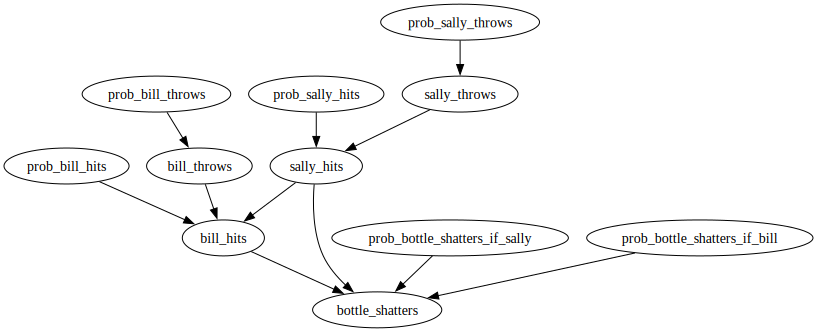

In [98]:
def stones_model():
    prob_sally_throws = pyro.sample("prob_sally_throws", dist.Beta(1, 1))
    prob_bill_throws = pyro.sample("prob_bill_throws", dist.Beta(1, 1))
    prob_sally_hits = pyro.sample("prob_sally_hits", dist.Beta(1, 1))
    prob_bill_hits = pyro.sample("prob_bill_hits", dist.Beta(1, 1))
    prob_bottle_shatters_if_sally = pyro.sample(
        "prob_bottle_shatters_if_sally", dist.Beta(1, 1)
    )
    prob_bottle_shatters_if_bill = pyro.sample(
        "prob_bottle_shatters_if_bill", dist.Beta(1, 1)
    )

    sally_throws = pyro.sample("sally_throws", dist.Bernoulli(prob_sally_throws))
    bill_throws = pyro.sample("bill_throws", dist.Bernoulli(prob_bill_throws))

    # if Sally throws, she hits with probability prob_sally_hits
    # hits with pr=0 otherwise
    new_shp = torch.where(sally_throws == 1, prob_sally_hits, 0.0)

    sally_hits = pyro.sample("sally_hits", dist.Bernoulli(new_shp))

    # if Bill throws, he hits with probability prob_bill_hits
    # if sally doesn't hit sooner,
    # misses otherwise
    new_bhp = torch.where(
        bill_throws.bool() & (~sally_hits.bool()),
        prob_bill_hits,
        torch.tensor(0.0),
    )

    bill_hits = pyro.sample("bill_hits", dist.Bernoulli(new_bhp))

    # you can use a analogous move to model the bottle shattering
    # if being hit by a stone doesn't deterministically
    # shatter the bottle
    new_bsp = torch.where(
        bill_hits.bool(),
        prob_bottle_shatters_if_bill,
        torch.where(
            sally_hits.bool(),
            prob_bottle_shatters_if_sally,
            torch.tensor(0.0),
        ),
    )

    bottle_shatters = pyro.sample("bottle_shatters", dist.Bernoulli(new_bsp))

    return {
        "sally_throws": sally_throws,
        "bill_throws": bill_throws,
        "sally_hits": sally_hits,
        "bill_hits": bill_hits,
        "bottle_shatters": bottle_shatters,
    }


with ExtractSupports() as extract_supports:
    stones_model()
    stones_supports = {k: constraints.boolean if not k.startswith("prob_") else v for k, v in extract_supports.supports.items()}

pyro.render_model(stones_model)

For now let us assume that the relevant probabilities are 1 (this forces both Sally and Bill to throw stones, makes them perfectly accurate and makes the bottle always shatter if hit). Let us start with the type of analysis we performed for the forest fire case. 

In [186]:
query = SearchForExplanation(
    supports=stones_supports,
    antecedents={"sally_throws": torch.tensor(1.0)},
    consequents={"bottle_shatters": torch.tensor(1.0)},
    witnesses={},
    alternatives={"sally_throws": torch.tensor(0.0)},
    consequent_scale=1e-5,
)(condition(
    data={
        "prob_sally_throws": torch.tensor(1.0),
        "prob_bill_throws": torch.tensor(1.0),
        "prob_sally_hits": torch.tensor(1.0),
        "prob_bill_hits": torch.tensor(1.0),
        "prob_bottle_shatters_if_sally": torch.tensor(1.0),
        "prob_bottle_shatters_if_bill": torch.tensor(1.0),
    }
)(stones_model))

logp, trace, mwc = importance_infer(num_samples=10000)(query)()
print(torch.exp(logp))

tensor(1.0013e-05)


Sally's throw does not satisfy the but-for condition: if she hadn't thrown the rock, the bottle would still have shattered. Of course, the combined event of Sally throwing a rock and Bob throwing a rock is a but-for cause of the bottle shattering. But that doesn't capture the clear asymmetry at work here. Intuitively, Sally's throw is the (actual) cause of the bottle breaking in a way that Bob's throw isn't.  Sally's throw actually caused the bottle to shatter and Bob's throw didn't, in part because Bob's stone didn't actually hit the bottle.

An intuitive solution to the problem, inspired by the  Pearl-Halpern definition of actual causality (which we discuss in [another notebook](https://basisresearch.github.io/chirho/actual_causality.html)) is to say that **in answering actual causality queries, we need to consider what happens when part of the actual context is kept fixed.** For instance, in the bottle shattering example, given the observed fact that Bob’s stone didn’t hit, in the counterfactual world in which we keep this observed fact fixed, if Sally nad not thrown the stone, the bottle in fact would not have shattered. 


For this reason, our handler allows not only stochastic preemption of interventions (to approximate the search through possible antecedent sets) but also stochastic witness preemption of those nodes that are considered part of the context (these needn't exclude each other). In a witness preemption, we ensure that the counterfactual value is identical to the factual one (and by applying it randomly to candidate witness nodes, we approximate a search through all possible context sets).

In [292]:
query = SearchForExplanation(
    supports=stones_supports,
    antecedents={"sally_throws": torch.tensor(1.0)},
    consequents={"bottle_shatters": torch.tensor(1.0)},
    witnesses={"bill_hits": None},
    alternatives={"sally_throws": torch.tensor(0.0)},
    consequent_scale=1e-5
)(condition(
    data={
        "prob_sally_throws": torch.tensor(1.0),
        "prob_bill_throws": torch.tensor(1.0),
        "prob_sally_hits": torch.tensor(1.0),
        "prob_bill_hits": torch.tensor(1.0),
        "prob_bottle_shatters_if_sally": torch.tensor(1.0),
        "prob_bottle_shatters_if_bill": torch.tensor(1.0),
    }
)(stones_model))

logp, trace, mwc, logw = importance_infer(num_samples=100000)(query)()
print(torch.exp(logp))

tensor([-1.1512e+01, -1.1512e+01, -1.1512e+01,  ..., -2.3024e+01,
        -1.1512e+01, -2.0027e-05])
tensor(0.2495)


In [151]:
trace.nodes.keys()
print(trace.nodes['sally_throws']["value"].squeeze())
print(trace.nodes['__cause____antecedent_sally_throws']["value"].shape)
print(trace.nodes['bill_hits']["value"].shape)
print(trace.nodes['__cause____witness_bill_hits']["value"].shape)
print(trace.nodes['bottle_shatters']["value"].squeeze())
print(trace.nodes['__cause____consequent_bottle_shatters']["log_prob"].squeeze())

tensor(1.)
torch.Size([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
torch.Size([1, 1, 1, 1, 1, 3, 1, 1, 1, 1])
torch.Size([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1., 0., 1.])
tensor([ 0.0000, -0.0101, -0.0101])


Admittedly, our search through contexts is very simple and degenerate, as the only part of the actual context which stochastically is kept fixed at the factual value is `bill_hits`. But already with this search, sally throwing is diagnosed as having non-null probability. In fact, the definition of actual causality in Halpern's book (*Actual causality*) contains an existential quantifier: a variable is an actual cause if there is at least one context in which a change in the outcome variable would result from changing the antecedent to have an alternative value, so our search provides a correct diagnosis here.

Crucally, as intended, an analogous inference for whether `bill_throws` is a cause of the bottle shattering, yields a different
result and assigns null causal role to bill.

In [203]:
query = SearchForExplanation(
    supports=stones_supports,
    antecedents={"bill_throws": torch.tensor(1.0)},
    consequents={"bottle_shatters": torch.tensor(1.0)},
    witnesses={"sally_hits": None},
    alternatives={"bill_throws": torch.tensor(0.0)},
    consequent_scale=1e-5,
)(condition(
    data={
        "prob_sally_throws": torch.tensor(1.0),
        "prob_bill_throws": torch.tensor(1.0),
        "prob_sally_hits": torch.tensor(1.0),
        "prob_bill_hits": torch.tensor(1.0),
        "prob_bottle_shatters_if_sally": torch.tensor(1.0),
        "prob_bottle_shatters_if_bill": torch.tensor(1.0),
    }
)(stones_model))

logp, trace, mwc = importance_infer(num_samples=10000)(query)()
print(torch.exp(logp))

tensor(1.0013e-05)


## Probability of causation and responsibility

We might use non-trivial probabilities and be interested in more involved queries. Suppose we aren't sure what part of the context we want to hold fixed, allowing both `sally_hits` and `bill_hits` to be witness candidates, so we attach equal weights to all four possible context sets. 

Suppose also that beyond knowing the non-degenerate probabilities involved, we don't know who threw the stone, and we only observed the bottle has been shattered. We can use the handler to estimate the answer to a somewhat different question involving the probabilities that changing the value of `sally_throws` or changing the value of `billy_throws` (whatever these are in the factual world) would lead to a change in the outcome variables, and that fixing them to be at the factual values would result in the outcome variable having the same value. We also allow both `sally_hits` and `bill_hits` as potential witnesses.

For example, we can sample to estimate quantities such as the fraction of possible causes of the bottle shattering in which Sally and Billy are each responsibile:

In [300]:
query = SearchForExplanation(
    supports=stones_supports,
    antecedents={"sally_throws": None, "bill_throws": None},
    consequents={"bottle_shatters": torch.tensor(1.0)},
    witnesses={"sally_hits": None, "bill_hits": None},
    consequent_scale=1e-5
)(condition(
    data={
        "prob_sally_throws": torch.tensor(1.0),
        "prob_bill_throws": torch.tensor(1.0),
        "prob_sally_hits": torch.tensor(1.0),
        "prob_bill_hits": torch.tensor(1.0),
        "prob_bottle_shatters_if_sally": torch.tensor(1.0),
        "prob_bottle_shatters_if_bill": torch.tensor(1.0),
        "bottle_shatters": torch.tensor(1.0),
    }
)(stones_model))

logp, trace, mwc, logw = importance_infer(num_samples=10)(query)()

print(logp)

print(torch.exp(logp))

nodes = trace.nodes["_RETURN"]["value"]

print(trace.nodes["sally_throws"]["value"].shape)
print(nodes["sally_throws"].shape)
with mwc:
    print(gather(nodes["sally_throws"], IndexSet(sally_throws={0})).squeeze())
    print(gather(nodes["sally_throws"], IndexSet(sally_throws={1})).squeeze())
    print(gather(nodes["sally_throws"], IndexSet(sally_throws={2})).squeeze())

    print(gather(nodes["bill_throws"], IndexSet(bill_throws={0})).squeeze())
    print(gather(nodes["bill_throws"], IndexSet(bill_throws={1})).squeeze())
    print(gather(nodes["bill_throws"], IndexSet(bill_throws={2})).squeeze())

    st_responsible = gather(nodes["sally_throws"], IndexSet(sally_throws={1})) != \
        gather(nodes["sally_throws"], IndexSet(sally_throws={2}))

    bt_responsible = gather(nodes["bill_throws"], IndexSet(bill_throws={1})) != \
        gather(nodes["bill_throws"], IndexSet(bill_throws={2}))

print("Degree of responsibility of Sally:", st_responsible.sum() / st_responsible.numel())
print("Degree of responsibility of Billy:", bt_responsible.sum() / bt_responsible.numel())

tensor([-11.5116, -23.0245, -23.0245, -11.5116, -23.0245, -23.0245, -11.5116,
        -23.0245, -11.5116, -23.0245])
tensor(-12.4279)
tensor(4.0055e-06)
torch.Size([10, 1, 1, 1, 1, 1, 1, 1, 1, 1])
torch.Size([10, 1, 1, 1, 1, 3, 1, 1, 1, 1])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 0., 1., 0., 1., 1., 1., 1., 1., 0.])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 1., 1.])
Degree of responsibility of Sally: tensor(0.8000)
Degree of responsibility of Billy: tensor(0.8000)


Note that we assumed Sally to be more likely to throw, more likely to hit, and more likely to shatter the bottle if she hits. For this reason, we expect her to be more likely to be causally responsible for the outcome. Conceptually, these estimates are impacted by some hyperparameters, such as witness preemption probabilities, so perhaps a bit more clarity on can be gained if we think we have a complete list of potential causes and normalize. 

In [298]:
st_responsible2 = st_responsible.float()
st_responsible2[st_responsible2 == 0.0] = 9.2
st_responsible2[st_responsible2 == 1.0] = 1.0
# st_responsible2
logp = torch.logsumexp(st_responsible2.squeeze().float() * logw, dim=0) - torch.log(torch.tensor(1000))
torch.exp(logp)

tensor(0.8100)

In [261]:
st_responsible.squeeze()

tensor([False, False,  True,  True,  True,  True,  True, False,  True, False,
         True,  True, False,  True,  True, False,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True, False,  True,  True,  True,  True, False,  True,  True, False,
        False, False,  True,  True,  True,  True,  True, False,  True,  True,
        False,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True, False,  True, False,  True,
         True,  True, False,  True, False,  True,  True,  True,  True,  True,
         True, False,  True, False,  True, False, False,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True, False, False,  True,
        False,  True,  True,  True,  True,  True,  True,  True, 